Federated Learning prototype working

In [ ]:
class Client:

    def __init__(self, model = None) -> None:
        self.model = model

    def trainLocal(self,res):
        self.model = res

    def receiveModel(self,new_model):
        self.model = new_model

    # def sendModel():
    #     pass

class Server:

    def __init__(self, model = None) -> None:
        self.model = model

    def aggregate(self, received_models):
        result = ''
        for model in received_models:
            result += model
        return result

    def receiveModels(self,clients_list):
        received_models = []
        for client in clients_list:
            received_models.append(client.model)
        return received_models

    def sendModel(self,clients_list, new_model):
        for client in clients_list:
            client.receiveModel(new_model)

# clients and server initialization
c1 = Client()
c2 = Client()
s = Server()

for epoch in range(5):
    # server sends the model to the clients - model sync
    s.sendModel([c1,c2],"ServerModel")

    # clients trains the model locally
    c1.trainLocal(f"{epoch}")
    c2.trainLocal(f"{epoch}")

    # clients sends back each model to the server - upload
    global_model = s.aggregate(s.receiveModels([c1,c2])) 

    # server sends back global model to each client - model sync
    s.sendModel([c1,c2],global_model)

print(c1.model,c2.model)




Federated Learning prototype 2 working

In [ ]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
import random

class Client:

    def __init__(self, model = None) -> None:
        self.model = model

    def trainLocal(self,step):
        self.model += step

    def receiveModel(self,new_model):
        self.model = new_model

    # def sendModel():
    #     pass

class Server:

    def __init__(self, model = None) -> None:
        self.model = model

    def aggregate(self, received_models):
        return sum(received_models)
    
    def receiveModels(self,clients_list):
        received_models = []
        for client in clients_list:
            received_models.append(client.model)
        return received_models

    def sendModel(self,clients_list, new_model):
        for client in clients_list:
            client.receiveModel(new_model)

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train_reshaped = X_train.reshape(X_train.shape[0],X_train.shape[1] * X_train.shape[2])
y_train_reshaped = y_train.reshape(y_train.shape[0],1).ravel()
X_test_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1] * X_test.shape[2])
y_test_reshaped = y_test.reshape(y_test.shape[0],1).ravel()

# clients and server initialization
c1 = Client(0)
c2 = Client(0)
s = Server(0)

accuracies = []
epochs = []

# server sends the model to the clients - model sync
s.sendModel([c1,c2],s.model)

for epoch in range(5):

    # clients trains the model locally
    c1.trainLocal(1)
    c2.trainLocal(2)
    
    print(f'c1.model:{c1.model}\nc2.model:{c2.model}')

    # clients sends back each model to the server - upload - and the server aggregates the models
    global_model = s.aggregate(s.receiveModels([c1,c2])) 

    print(f'global model: {global_model}\n')

    # server sends back global model to each client - model sync
    s.sendModel([c1,c2],global_model)




Código funcionando

In [ ]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
import random

class Client:

    def __init__(self, model = None) -> None:
        self.model = model

    def trainLocal(self,Xi,yi):
        self.model.fit(Xi,yi)
        self.client_weight = len(Xi)

    def receiveModel(self,new_model):
        self.model = new_model

class Server:

    def __init__(self, model = None) -> None:
        self.model = model

    def aggregate(self, clients):

        clients_weights = np.array([client.client_weight for client in clients])

        # Weighted FedAvg: Agregação dos modelos dos clientes com pesos
        coefs = []
        for layer in range(len(self.model.coefs_)):
            weighted_avg_coefs = np.average([client.model.coefs_[layer] for client in clients], axis=0, weights=clients_weights)
            # self.model.coefs_[layer] = weighted_avg_coefs
            coefs.append(weighted_avg_coefs)
        setattr(self.model,'coefs',coefs)

        return self.model
    
    def receiveModels(self,clients_list):
        received_models = []
        for client in clients_list:
            received_models.append(client.model)
        return received_models

    def sendModel(self,clients_list, new_model):
        for client in clients_list:
            client.receiveModel(new_model)

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train_reshaped = X_train.reshape(X_train.shape[0],X_train.shape[1] * X_train.shape[2])
y_train_reshaped = y_train.reshape(y_train.shape[0],1).ravel()
X_test_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1] * X_test.shape[2])
y_test_reshaped = y_test.reshape(y_test.shape[0],1).ravel()

# clients and server initialization
c1 = Client()
c2 = Client()
c3 = Client()
c4 = Client()
s = Server(MLPClassifier())

accuracies = []
epochs = []

# server sends the model to the clients - model sync
s.sendModel([c1,c2,c3,c4],s.model)

epochs = []
accuracies = []
for epoch in range(10):

    # clients trains the model locally
    c1.trainLocal(X_train_reshaped[:100],y_train_reshaped[:100])
    c2.trainLocal(X_train_reshaped[100:200],y_train_reshaped[100:200])
    c3.trainLocal(X_train_reshaped[200:300],y_train_reshaped[200:300])
    c4.trainLocal(X_train_reshaped[300:400],y_train_reshaped[300:400])
    
    # print(f'c1.model:{c1.model}\nc2.model:{c2.model}')

    # clients sends back each model to the server - upload - and the server aggregates the models
    global_model = s.aggregate([c1,c2,c3,c4]) 

    # print(f'global model: {global_model}\n')

    # server sends back global model to each client - model sync
    s.sendModel([c1,c2,c3,c4],global_model)

    accuracy = accuracy_score(y_test_reshaped[:10], global_model.predict(X_test_reshaped[:10])) # Test Accuracy

    epochs.append(epoch)
    accuracies.append(accuracy)

plt.plot(epochs,accuracies)



In [ ]:
import numpy as np
s = [
        [np.array([[1,2],[3,4]]),np.array([[5,6,7],[8,9,10]])],
        [np.array([[11,12],[13,14]]),np.array([[15,16,17],[18,19,20]])]
    ]

wg = np.array([2,3])

s

In [ ]:
# [
#     [2,4]
#     [6,8]
# ]

# [
#     [33,36]
#     [39,42]
# ]

In [ ]:
for layer in range(len(s[0])):
    weighted_avg_coefs = np.average([client[layer] for client in s], axis=0, weights=wg)
    print(weighted_avg_coefs)

The Best

Epoch 1/2
4/4 [==============================] - 2s 4ms/step - loss: 2.2663 - accuracy: 0.1300
Epoch 2/2
4/4 [==============================] - 0s 5ms/step - loss: 2.1728 - accuracy: 0.1300
Epoch 1/2
4/4 [==============================] - 2s 4ms/step - loss: 2.1905 - accuracy: 0.0800
Epoch 2/2
4/4 [==============================] - 0s 4ms/step - loss: 2.0907 - accuracy: 0.1300
Epoch 1/2
4/4 [==============================] - 2s 4ms/step - loss: 2.0830 - accuracy: 0.2000
Epoch 2/2
4/4 [==============================] - 0s 4ms/step - loss: 1.9673 - accuracy: 0.3800
Epoch 1/2
4/4 [==============================] - 2s 4ms/step - loss: 2.0163 - accuracy: 0.3000
Epoch 2/2
4/4 [==============================] - 0s 4ms/step - loss: 1.8692 - accuracy: 0.4000
Epoch 1/2
4/4 [==============================] - 2s 4ms/step - loss: 1.7660 - accuracy: 0.4800
Epoch 2/2
4/4 [==============================] - 0s 4ms/step - loss: 1.5986 - accuracy: 0.5300
Epoch 1/2
4/4 [==============================] - 2

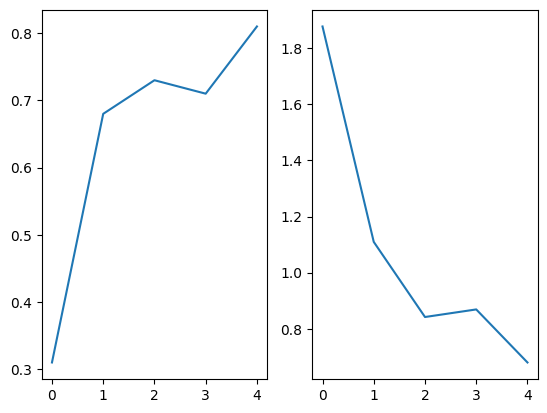

In [2]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

class Client:

    def __init__(self, model = None) -> None:
        self.model = model

    def trainLocal(self,Xi,yi):

        self.client_weight = len(Xi)

        # Compilando o modelo e definindo os pesos iniciais
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        # initial_weights = ... # Define os pesos iniciais desejados
        # self.model.set_weights(initial_weights)

        # Treinando o modelo
        self.model.fit(Xi, yi, epochs=2, batch_size=32)

    def receiveModel(self,new_model):
        self.model = new_model

class Server:

    def __init__(self, model = None) -> None:
        self.model = model

    def aggregate(self, clients):

        clients_wgs = [client.client_weight for client in clients]
        clients_wgs_norm = np.array(clients_wgs) / np.sum(clients_wgs)

        # wgs_1 = [client.model.get_weights()[0] * wgs_norm for client,wgs_norm in zip(clients,clients_wgs_norm)] # layer 1
        # bss_1 = [client.model.get_weights()[1] * wgs_norm for client,wgs_norm in zip(clients,clients_wgs_norm)] # layer 1
        # wgs_2 = [client.model.get_weights()[2] * wgs_norm for client,wgs_norm in zip(clients,clients_wgs_norm)] # layer 2
        # bss_2 = [client.model.get_weights()[3] * wgs_norm for client,wgs_norm in zip(clients,clients_wgs_norm)] # layer 2

        # weights = [np.sum(wgs_1,axis=0),np.sum(bss_1,axis=0),np.sum(wgs_2,axis=0),np.sum(bss_2,axis=0)]

        # [[c0w0,c0w1,c0w2,c0w3],[c1w0,c1w1,c1w2,c1w3],[c2w0,...],...]. For each layer 2 weights: weights and biases
        wbs = [[client.model.get_weights()[i] * wgs_norm for i in range(len(2*client.model.layers))] for client,wgs_norm in zip(clients,clients_wgs_norm)]
        weights = [np.sum(z,axis=0) for z in zip(*wbs)]

        self.model.set_weights(weights)

        return self.model

    def sendModel(self,clients_list, new_model):
        for client in clients_list:
            client.receiveModel(new_model)

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Pré-processamento dos dados
X_train = X_train.reshape((60000, 28 * 28))
X_train = X_train.astype('float32') / 255

X_test = X_test.reshape((10000, 28 * 28))
X_test = X_test.astype('float32') / 255

y_train = to_categorical(y_train)  # Convertendo rótulos para one-hot encoding
y_test = to_categorical(y_test)    # Convertendo rótulos para one-hot encoding

model = Sequential()
model.add(Dense(units=32, activation='relu', input_dim=784))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

# clients and server initialization
c1 = Client()
c2 = Client()
c3 = Client()
c4 = Client()

clients_list = [c1,c2,c3,c4]
s = Server(model)

accuracies = []
epochs = []

# server sends the model to the clients - model sync
s.sendModel(clients_list,s.model)

epochs = []
accuracies = []
losses = []
for epoch in range(5):

    # clients trains the model locally
    c1.trainLocal(X_train[:100],y_train[:100])
    c2.trainLocal(X_train[100:200],y_train[100:200])
    c3.trainLocal(X_train[200:300],y_train[200:300])
    c4.trainLocal(X_train[300:400],y_train[300:400])
    
    # print(f'c1.model:{c1.model}\nc2.model:{c2.model}')

    # clients sends back each model to the server - upload - and the server aggregates the models
    global_model = s.aggregate(clients_list) 

    # print(f'global model: {global_model}\n')

    # server sends back global model to each client - model sync
    s.sendModel(clients_list,global_model)

    # accuracy = accuracy_score(y_test[:10], global_model.predict(X_test[:10])) # Test Accuracy
    score = global_model.evaluate(X_test[:100], y_test[:100], verbose=0)

    epochs.append(epoch)
    # accuracies.append(accuracy)
    losses.append(score[0])
    accuracies.append(score[1])

fig, axs = plt.subplots(1,2)
axs[0].plot(epochs,accuracies)
axs[1].plot(epochs,losses)
# plt.plot(epochs,accuracies)



In [2]:
m1 = Sequential()
m1.add(Dense(units=32, activation='relu', input_dim=784))
m1.add(Dense(units=10, activation='softmax'))

m1.get_weights()

m2 = Sequential()
m2.add(Dense(units=32, activation='relu', input_dim=784))
m2.add(Dense(units=10, activation='softmax'))

m2.get_weights()

[array([[ 0.02785119, -0.08219455,  0.06479392, ..., -0.08147128,
          0.05542267,  0.06256872],
        [-0.06699853,  0.08243904, -0.0160462 , ...,  0.06649793,
          0.03744928, -0.0379297 ],
        [ 0.01545348, -0.05341031, -0.07135535, ..., -0.00568341,
         -0.05934948,  0.04784179],
        ...,
        [-0.06351814, -0.05416472, -0.00346957, ...,  0.02417977,
          0.05878209, -0.01028312],
        [-0.07754216,  0.00220662, -0.02537899, ...,  0.04321098,
         -0.0744891 ,  0.00395099],
        [ 0.05490423,  0.06019986,  0.04900538, ...,  0.05099162,
         -0.01076896, -0.03968911]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([[ 0.08983973,  0.34192887, -0.06328103, -0.33576736,  0.28255138,
         -0.12287065, -0.20470484, -0.2244165 , -0.20330031, -0.35616443],
        [ 0.10175446, -0.19161645,  0.291

In [3]:
print(m1.get_weights()[0].shape)
print(m1.get_weights()[1].shape)
print(m1.get_weights()[2].shape)
print(m1.get_weights()[3].shape)
    
m1.get_weights()[0] + m2.get_weights()[0]


# print(m1.get_weights()[0].shape)
# print(m1.get_weights()[1].shape)

(784, 32)
(32,)
(32, 10)
(10,)


array([[-0.04278383, -0.07689586,  0.02326798, ..., -0.10106772,
         0.01831246,  0.00366741],
       [-0.05319307,  0.0883598 , -0.08007868, ...,  0.0550584 ,
         0.0628425 , -0.08216938],
       [-0.0430998 ,  0.02569816, -0.05039059, ..., -0.03888798,
        -0.1050312 ,  0.07908993],
       ...,
       [-0.1399771 , -0.05415047, -0.06020232, ...,  0.01563308,
        -0.02424748, -0.04448526],
       [-0.02321382,  0.06953295,  0.00206159, ...,  0.08181629,
        -0.00843719,  0.02142394],
       [ 0.05056055, -0.02177432,  0.06691575, ...,  0.08394525,
        -0.07733964, -0.01135356]], dtype=float32)

In [4]:
np.sum([m1.get_weights()[0], m2.get_weights()[0]], axis=0)

array([[-0.04278383, -0.07689586,  0.02326798, ..., -0.10106772,
         0.01831246,  0.00366741],
       [-0.05319307,  0.0883598 , -0.08007868, ...,  0.0550584 ,
         0.0628425 , -0.08216938],
       [-0.0430998 ,  0.02569816, -0.05039059, ..., -0.03888798,
        -0.1050312 ,  0.07908993],
       ...,
       [-0.1399771 , -0.05415047, -0.06020232, ...,  0.01563308,
        -0.02424748, -0.04448526],
       [-0.02321382,  0.06953295,  0.00206159, ...,  0.08181629,
        -0.00843719,  0.02142394],
       [ 0.05056055, -0.02177432,  0.06691575, ...,  0.08394525,
        -0.07733964, -0.01135356]], dtype=float32)

In [14]:
v1 = [1,2,3,4,5]
v2 = [6,7,8,9,10]
v3 = [11,12,13,14,15]
v = [v1,v2,v3]

for z in zip(*v):
    print(z)
    print(np.sum(z,axis=0))

(1, 6, 11)
18
(2, 7, 12)
21
(3, 8, 13)
24
(4, 9, 14)
27
(5, 10, 15)
30
